In [1]:
import numpy as np
import numpy.ma as ma
from scipy import ndimage
from scipy import misc
from scipy import linalg
import h5py
import os

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import glob

import time
from progress import ProgressBar, query_yes_no

import mayavi.mlab as mlab

%matplotlib inline
# %load_ext imayavi

In [5]:
mpl.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

# Processing functions

## Compute Hessian matrix at the center of a volume

In [6]:
def hessian_ctr3(di, C):
    a1 = np.array([-1.0, 9.0, -45.0, 0.0, 45.0, -9.0, 1.0])/60
    a2 = np.array([2, -27, 270, -490, 270, -27, 2])/180.0

    #these both automatically round down, which is what we want
    n = len(a1)/2
    c = np.array(C.shape)/2
    c = c[0]
    
    ic = np.arange(c-n,c+n+1)
    
    H = np.zeros((3,3))
    H[0,0] = sum(C[ic,c,c] * a2) / di**2
    H[1,1] = sum(C[c,ic,c] * a2) / di**2
    H[2,2] = sum(C[c,c,ic] * a2) / di**2
    
    ic1 = ic[:,np.newaxis]
    ic2 = ic[np.newaxis,:]
    
    H[0,1] = np.sum( np.sum( C[ic1,ic2,c] * a1[:,np.newaxis], axis=0) * a1) / di**2
    H[0,2] = np.sum( np.sum( C[ic1,c,ic2] * a1[:,np.newaxis], axis=0) * a1) / di**2
    H[1,2] = np.sum( np.sum( C[c,ic1,ic2] * a1[:,np.newaxis], axis=0) * a1) / di**2

    H[1,0] = H[0,1]
    H[2,0] = H[0,2]
    H[2,1] = H[1,2]
    
    return H

## Use the eigenvector with the smallest eigenvalue to estimate fiber angle

In [7]:
def get_volume_autocorr(V):
    #first construct a window for the FFT
    sz = V.shape
    assert(all(np.equal(sz,sz[0])))
    
    wind1 = np.hamming(sz[0])
    wind = wind1[:,np.newaxis,np.newaxis] * wind1[np.newaxis,:,np.newaxis] * wind1[np.newaxis,np.newaxis,:]
    
    #multiply by the window
    V = V*wind
    
    #and get the autocorrelation volume
    F1 = np.fft.rfftn(V)
    C = np.fft.irfftn(F1 * np.conjugate(F1))
    C = np.fft.fftshift(C)

    C = C / np.max(C)
    
    return C

In [8]:
def get_angle3(C):
    H = hessian_ctr3(1,C)
    w,vr = linalg.eig(H)
    
    ord = np.argsort(np.abs(w))
    vr = vr[:,ord]
    w = w[ord]
    
    return vr, w

# Run through the file

The file name

In [13]:
infile = 'Danio_16.h5'
outfile = 'Danio_16_angles.h5'

Get the size of the CT data, and set up the grid.

In [15]:
f = h5py.File(infile,'a')
imgdata = f['image']
print(imgdata.shape)

(1000, 1000, 552)


Get a plane through the middle of the volume, and check the pixel values

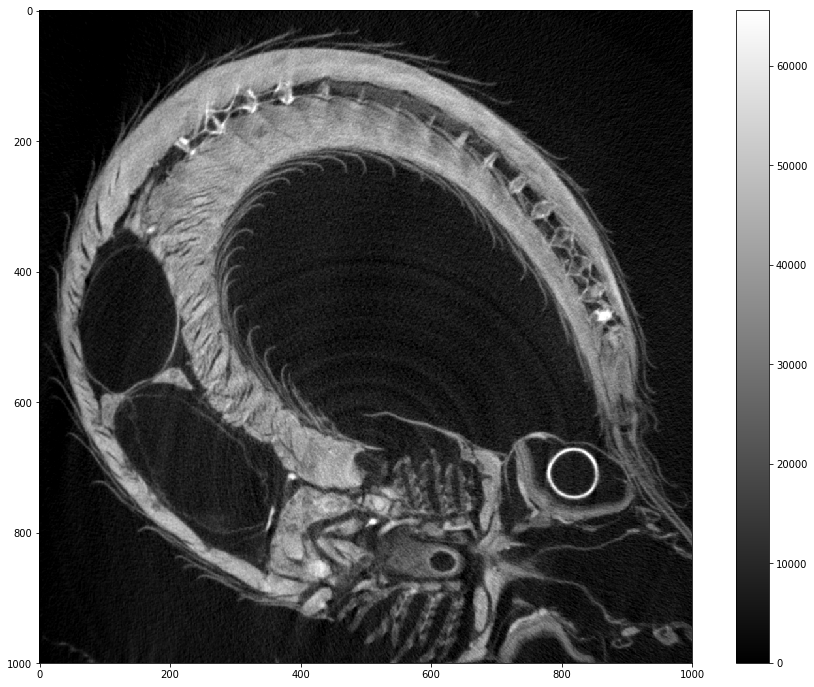

In [19]:
I = imgdata[:,:,300]
plt.imshow(I, cmap=mpl.cm.gray)
plt.colorbar()
plt.show()

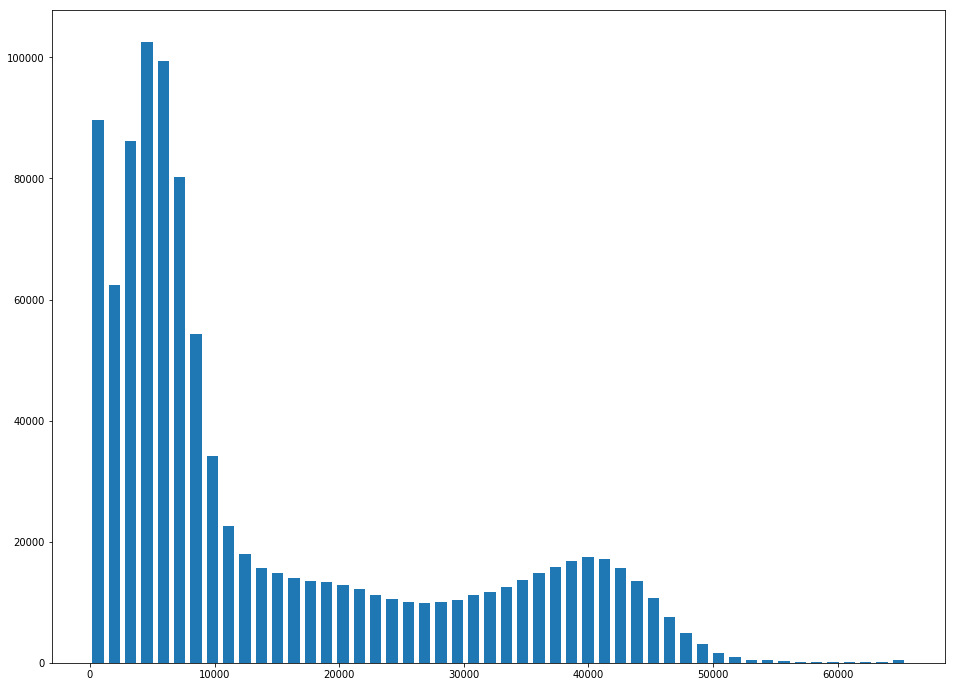

In [21]:
hist, bins = np.histogram(I, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

# Make the grid

In [22]:
volsz = 24
minint = 5000
i1 = np.arange(volsz/2,imgdata.shape[0]-volsz/2,volsz)
i2 = np.arange(volsz/2,imgdata.shape[1]-volsz/2,volsz)
i3 = np.arange(volsz/2,imgdata.shape[2]-volsz/2,volsz)

grid = np.meshgrid(i1,i2,i3,indexing='ij')
ind = np.meshgrid(range(len(i1)),range(len(i2)),range(len(i3)),indexing='ij')

Check the grid size

In [24]:
grid = np.array(grid)
print("grid.shape = {}, imgdata.shape = {}".format(grid.shape, imgdata.shape))

grid.shape = (3, 41, 41, 22), imgdata.shape = (1000, 1000, 552)


Find some cross sections through the middle of each axis

In [25]:
ctr = (20,20,11)
grid[(0,)+ctr],grid[(1,)+ctr],grid[(2,)+ctr]

(492.0, 492.0, 276.0)

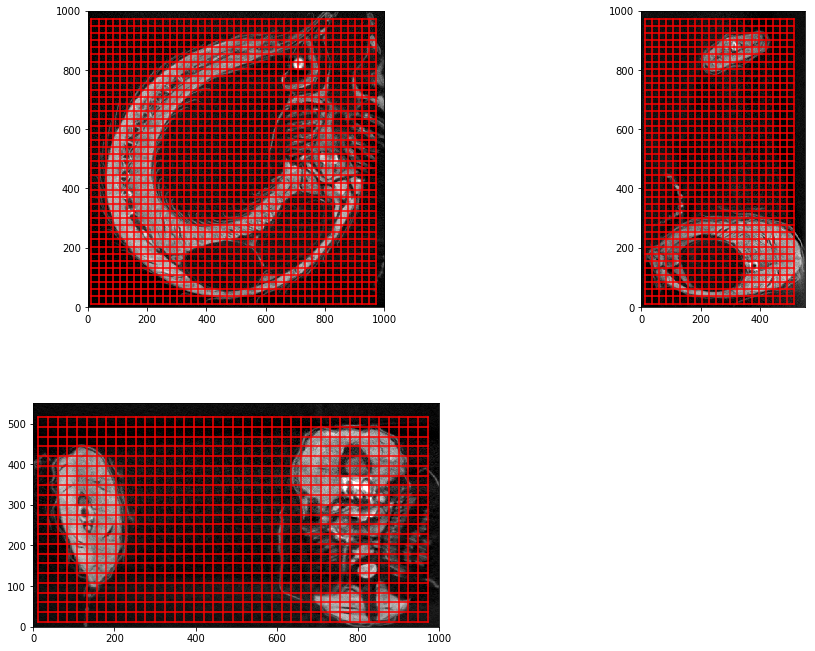

In [27]:
#%matplotlib qt
#%matplotlib inline
#rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

plt.subplot(2,2,1)
Ixy = imgdata[:,:,grid[(2,)+ctr]]
plt.imshow(Ixy.transpose(), cmap=mpl.cm.gray, origin='lower')

plt.plot(grid[0,:,:,ctr[2]],grid[1,:,:,ctr[2]],'r-', 
     np.transpose(grid[0,:,:,ctr[2]]),np.transpose(grid[1,:,:,ctr[2]]),'r-')
plt.autoscale(enable=True, tight=True)

plt.subplot(2,2,2)

Iyz = np.squeeze(imgdata[grid[(0,)+ctr],:,:])
plt.imshow(Iyz, cmap=mpl.cm.gray, origin='lower')
plt.plot(grid[2,ctr[0],:,:],grid[1,ctr[0],:,:],'r-', 
     np.transpose(grid[2,ctr[0],:,:]),np.transpose(grid[1,ctr[0],:,:]),'r-')
plt.autoscale(enable=True, tight=True)

plt.subplot(2,2,3)

Ixz = np.squeeze(imgdata[:,grid[(1,)+ctr],:])
plt.imshow(np.transpose(Ixz), cmap=mpl.cm.gray, origin='lower')
plt.plot(grid[0,:,ctr[1],:],grid[2,:,ctr[1],:],'r-', 
     np.transpose(grid[0,:,ctr[1],:]),np.transpose(grid[2,:,ctr[1],:]),'r-')
plt.autoscale(enable=True, tight=True)

plt.show()

Look at the image data on the grid

In [29]:
slices = tuple([slice(int(volsz/2),int(s1-volsz/2),volsz) for s1 in imgdata.shape])
V = imgdata[slices]

In [30]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0],grid[1],grid[2],V)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                 slice_index=int(V.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                 slice_index=int(V.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                 slice_index=int(V.shape[2]/2))

mlab.axes(extent=np.hstack((i1[[0,-1]], i2[[0,-1]], i3[[0,-1]])))

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

NameError: name 'mayavi_show_inline' is not defined

Turn it into a list of 3 element coordinates of the centers

In [18]:
grid = zip(*map(np.ndarray.flatten,grid))
ind = zip(*map(np.ndarray.flatten,ind))

Check getting volumes

This shows Z cross sections for a subset of volumes.

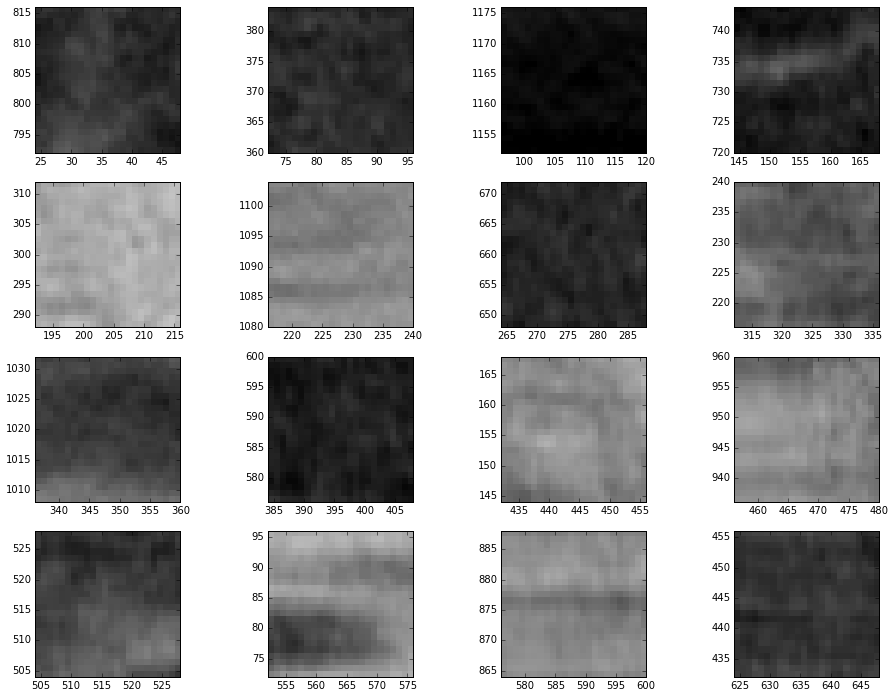

In [21]:
m,n = (4,4)
k = np.linspace(0,len(grid),m*n+2)
k = [int(k1) for k1 in k[1:-1]]

f, ax = subplots(m,n)

for ax1, ind1 in zip(np.ndarray.flatten(ax),k):
    v2 = int(volsz/2)
    loc = tuple([slice(c1-v2,c1+v2) for c1 in grid[ind1]])
    V = imgdata[loc]
    
    extent = [grid[ind1][0]-v2,grid[ind1][0]+v2, grid[ind1][1]-v2,grid[ind1][1]+v2]
    
    ax1.imshow(np.squeeze(V[0,:,:]), cmap=cm.gray, interpolation='nearest', extent=extent, vmin=0, vmax=40000)

Set up the output files

In [22]:
if os.path.exists(outfile):
    if query_yes_no('Overwrite existing file?',default='no'):
        os.remove(outfile)

Fout = h5.File(outfile,'w-')
eigvecdata = Fout.create_dataset('eigenvectors',(3,3,len(i1),len(i2),len(i3)),chunks=(3,1,4,4,4))
eigvaldata = Fout.create_dataset('eigenvalues',(3,1,len(i1),len(i2),len(i3)),chunks=(3,1,4,4,4))
intensitydata = Fout.create_dataset('intensity',(len(i1),len(i2),len(i3)),chunks=True)
centers = Fout.create_dataset('centers',data=grid)
indices = Fout.create_dataset('indices',data=ind)

Overwrite existing file? [y/N] y


Function for processing the data and writing to the files

In [23]:
def process_angle(ctr,ind):
    v2 = volsz/2
    loc = tuple([slice(c1-volsz/2,c1+volsz/2) for c1 in ctr])
    V = imgdata[loc]
    m = np.mean(V)
    
    intensitydata[ind[0],ind[1],ind[2]] = m

    if m > minint:
        C = get_volume_autocorr(V)
        vr, w = get_angle3(C)

        eigvecdata[:,:,ind[0],ind[1],ind[2]] = vr
        eigvaldata[:,0,ind[0],ind[1],ind[2]] = w.real
    
    return m

### The key step: Run through all the volume elements for processing

In [24]:
with ProgressBar(total=len(grid)) as prog:
    for ctr1,ind1 in zip(grid,ind):
        process_angle(ctr1,ind1)
        prog.update(1)
Fout.close()

[------------------------------------------------------------>] 100%  2m 3sec elapsed, 0sec remaining


# Now check the output

In [9]:
Fout = h5.File(outfile,'r')
eigvecdata = Fout['eigenvectors']
eigvaldata = Fout['eigenvalues']
intensitydata = Fout['intensity']

In [10]:
grid = np.array(np.meshgrid(i1,i2,i3,indexing='ij'))

Show the average intensity, just to make sure the data is reasonable

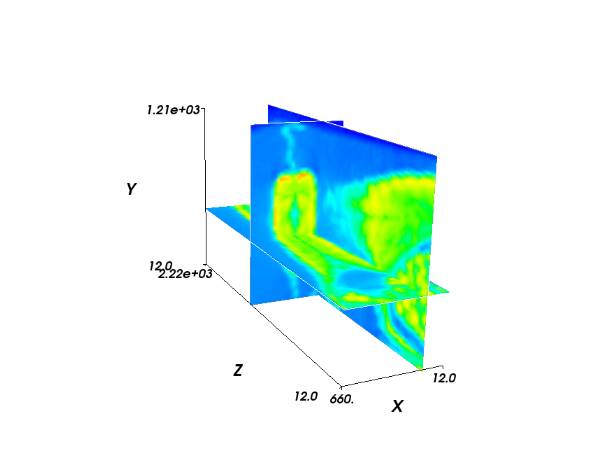

In [27]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0],grid[1],grid[2],np.array(intensitydata))
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                 slice_index=int(intensitydata.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                 slice_index=int(intensitydata.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                 slice_index=int(intensitydata.shape[2]/2))

mlab.axes(extent=np.hstack((i1[[0,-1]], i2[[0,-1]], i3[[0,-1]])))

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

Look at the vector field in a plane

In [24]:
sec = 13
grid[0,sec,0,0]
eigvecdata.shape

(3, 3, 28, 51, 93)

In [25]:
W = np.squeeze(eigvecdata[2,0,sec,:,:])
V = np.squeeze(eigvecdata[1,0,sec,:,:])

negW = W < 0
W[negW] = -W[negW]
V[negW] = -V[negW]

W = ma.masked_inside(W,-0.5,0.5)
V = ma.masked_where(ma.getmask(W), V)

In [33]:
eigvecdata[:,0,sec,19,35]

array([ 0.22928636,  0.05290515,  0.97192019], dtype=float32)

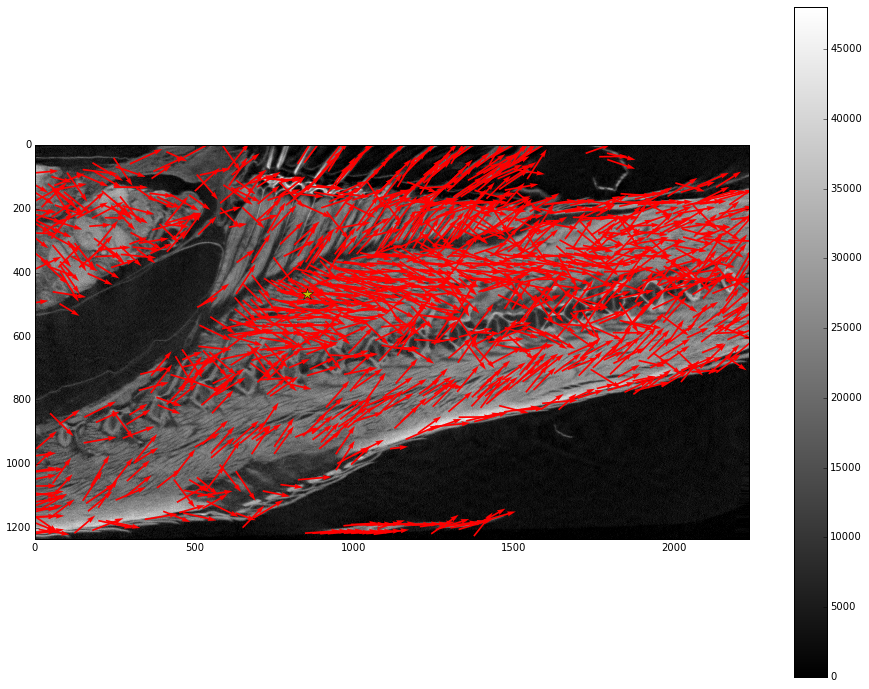

In [34]:
I = np.array(imgdata[grid[0,sec,0,0],:,:])
imshow(I, cmap=cm.gray)
colorbar()

quiver(grid[2,sec,:,:],grid[1,sec,:,:],W,-V, color='r',scale=20,pivot='middle')

plot(grid[2,sec,19,35],grid[1,sec,19,35],'y*',markersize=12)
autoscale(tight=True)
show()

Check a single volume

In [35]:
ind = (sec,19,35)
print grid[(slice(None),)+ind], grid[:,sec,19,35]

[324 468 852] [324 468 852]


In [36]:
v2 = int(volsz/2)
loc = tuple([slice(c1-v2,c1+v2) for c1 in grid[(slice(None),)+ind]])

Vox = imgdata[loc]

In [37]:
eigvecdata[(slice(None),0)+ind]

array([ 0.22928636,  0.05290515,  0.97192019], dtype=float32)

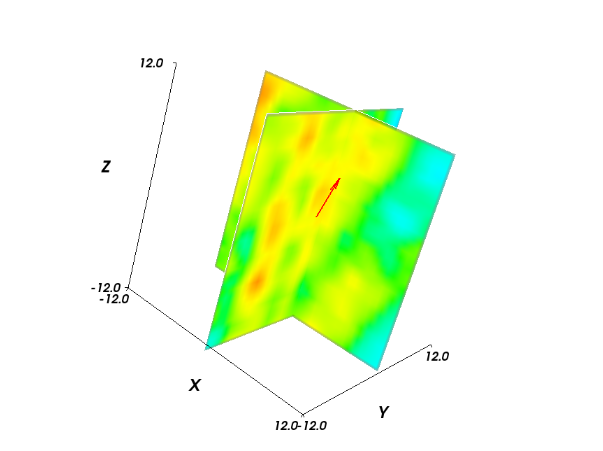

In [38]:
i1 = np.arange(-v2,v2)
Vgrid = np.meshgrid(i1,i1,i1,indexing='ij')

mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(Vgrid[0],Vgrid[1],Vgrid[2],Vox)
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                 slice_index=int(Vox.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                 slice_index=int(Vox.shape[1]/2))

mlab.quiver3d([0],[0],[0], [eigvecdata[(0,0)+ind]],[eigvecdata[(1,0)+ind]],[eigvecdata[(2,0)+ind]], scale_factor=5)

mlab.axes(extent=[-v2,v2,-v2,v2,-v2,v2])

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [29]:
grid.shape

(3, 21, 38, 69)

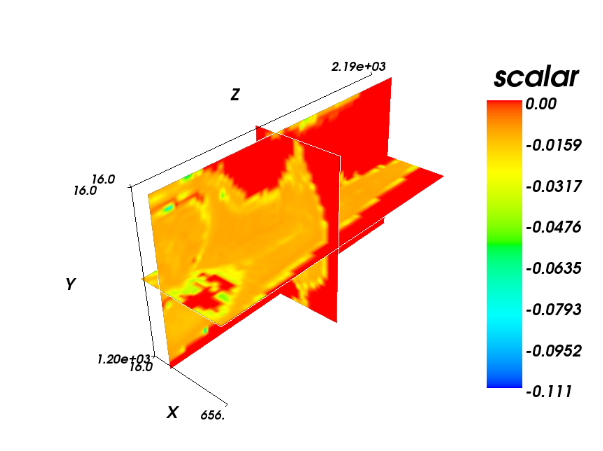

In [31]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0],grid[1],grid[2],np.squeeze(eigvaldata[0,0,:,:,:]))
mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                 slice_index=int(eigvaldata.shape[2]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                 slice_index=int(eigvaldata.shape[3]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                 slice_index=int(eigvaldata.shape[4]/2))

mlab.axes()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

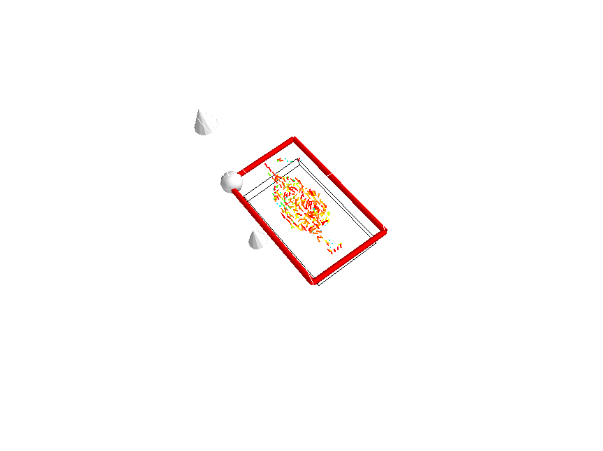

In [32]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))

#sf = mlab.pipeline.scalar_field(grid[0],grid[1],grid[2],np.array(intensitydata))
#mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes', 
#                                slice_index=int(eigvecdata.shape[4]/2))

vf = mlab.pipeline.vector_field(grid[0],grid[1],grid[2],
              np.squeeze(np.array(eigvecdata[0,0,:,:,:])),
              np.squeeze(np.array(eigvecdata[1,0,:,:,:])),
              np.squeeze(np.array(eigvecdata[2,0,:,:,:])),
                               scalars=np.abs(np.squeeze(eigvaldata[0,0,:,:,:])))
mlab.pipeline.vector_cut_plane(vf, mask_points=2, scale_factor=50, plane_orientation='z_axes')
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [13]:
imshow?

In [17]:
(grid[2,9,0,0]-volsz/2, grid[2,9,-1,-1]+volsz/2, grid[1,9,0,0]-volsz/2, grid[1,9,-1,-1]+volsz/2)

(0, 2208, 0, 1200)

In [40]:
eigval1 = np.squeeze(eigvaldata[0,0,sec,:,:])
eigval2 = np.squeeze(eigvaldata[1,0,sec,:,:])
eigval3 = np.squeeze(eigvaldata[2,0,sec,:,:])

/Users/etytel01/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


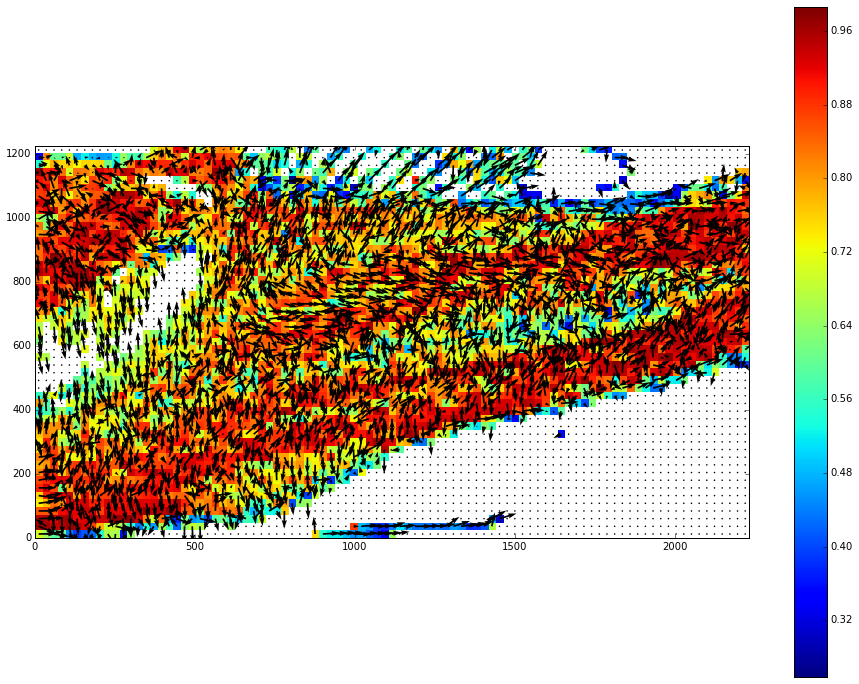

In [43]:
imshow(eigval1/eigval3, extent=(grid[2,sec,0,0]-volsz/2, grid[2,sec,-1,-1]+volsz/2, grid[1,sec,0,0]-volsz/2, grid[1,sec,-1,-1]+volsz/2),
      interpolation='nearest')
colorbar()

quiver(grid[2,sec,:,:],grid[1,sec,-1,-1]+volsz/2-grid[1,sec,:,:],
       np.squeeze(eigvecdata[2,0,sec,:,:]),-np.squeeze(eigvecdata[1,0,sec,:,:]),color='k',scale=40)

show()

/Users/etytel01/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


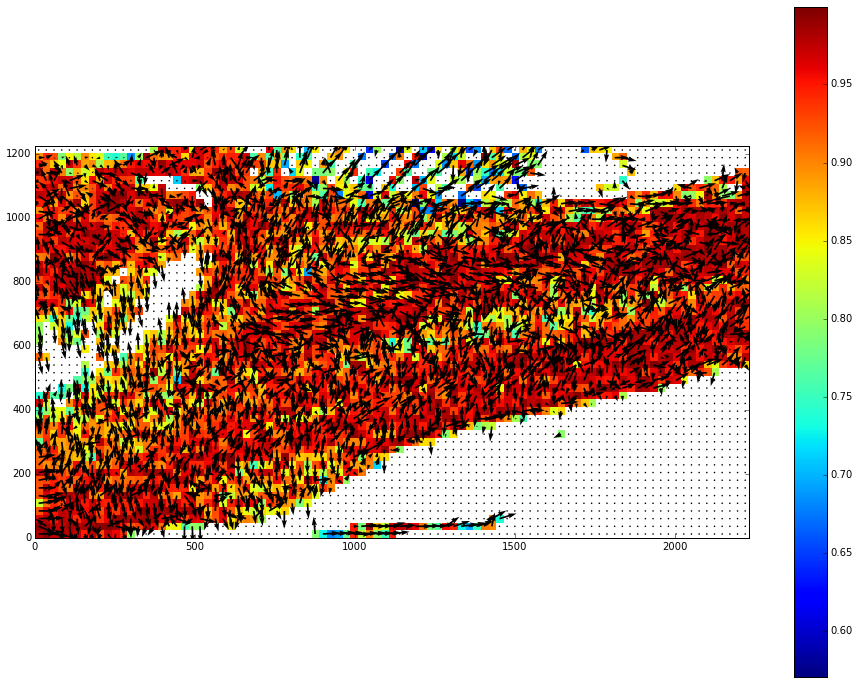

In [45]:
imshow(eigval1/eigval2, extent=(grid[2,sec,0,0]-volsz/2, grid[2,sec,-1,-1]+volsz/2, 
                                grid[1,sec,0,0]-volsz/2, grid[1,sec,-1,-1]+volsz/2),
      interpolation='nearest')
colorbar()

quiver(grid[2,sec,:,:],grid[1,sec,-1,-1]+volsz/2-grid[1,sec,:,:],
       np.squeeze(eigvecdata[2,0,sec,:,:]),-np.squeeze(eigvecdata[1,0,sec,:,:]),color='k',scale=40)

show()